<a href="https://colab.research.google.com/github/Luicarlozano/Ibero_IA/blob/main/Actividad_2_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import heapq

# --- 1. Módulo del Sistema Experto para Transporte ---
# Pondera el tiempo de viaje basándose en condiciones de la estación y la hora.

class SistemaExpertoTransporte:
    def __init__(self, condiciones_actuales):
        """
        Inicializa el sistema experto con las condiciones actuales.
        :param condiciones_actuales: Diccionario con datos como 'hora', 'tipo_estacion', etc.
        """
        self.condiciones = condiciones_actuales

    def calcular_tiempo_ajustado(self, tiempo_base, tipo_estacion):
        """
        Aplica reglas para modificar el tiempo de viaje entre estaciones.
        :param tiempo_base: Tiempo de viaje promedio sin congestión.
        :param tipo_estacion: Atributo de la estación de destino ('troncal', 'portal', 'intermedia').
        :return: El tiempo ajustado.
        """
        tiempo_ajustado = tiempo_base

        # Regla 1: Congestión en Portales en horas pico de lunes a viernes
        if self.condiciones.get('hora') == 'pico' and tipo_estacion == 'portal' and self.condiciones.get('tipo_dia') == 'L-V':
            tiempo_ajustado += tiempo_base * 0.7  # Aumenta el tiempo en 70% por la congestión

        # Regla 2: Congestión en Portales en horas pico de Sabado
        if self.condiciones.get('hora') == 'pico' and tipo_estacion == 'portal' and self.condiciones.get('tipo_dia') == 'S':
            tiempo_ajustado += tiempo_base * 0.2  # Aumenta el tiempo en 20% por la congestión

        # Regla 3: Demora en estaciones de alto flujo de lunes a vienes (troncales)
        if tipo_estacion == 'troncal' and self.condiciones.get('tipo_dia') == 'L-V':
            tiempo_ajustado += 4  # Penalización fija de 8 minutos

        # Regla 4: Demora en estaciones de alto flujo de sadabos (troncales)
        if tipo_estacion == 'troncal' and self.condiciones.get('tipo_dia') == 'S':
            tiempo_ajustado += 2  # Penalización fija de 5 minutos

        # Regla 5: Si no es hora pico y Lunes a viernes, el viaje es más rápido
        if self.condiciones.get('hora') == 'valle' and self.condiciones.get('tipo_dia')  == 'L-V':
            tiempo_ajustado -= tiempo_base * 0.1  # Descuento del 10%

        # Regla 6: Si no es hora pico y es Sabado, el viaje es más rápido
        if self.condiciones.get('hora') == 'valle' and self.condiciones.get('tipo_dia') == 'S':
            tiempo_ajustado -= tiempo_base * 0.2  # Descuento del 20%

        return max(tiempo_ajustado, 1) # Asegura que el tiempo no sea negativo

# --- 2. Algoritmo de Dijkstra Adaptado ---
# Encuentra la ruta más rápida usando los pesos dinámicos.

def dijkstra_transporte(red_transporte, inicio, destino, condiciones_actuales):
    """
    Algoritmo de Dijkstra para un sistema de transporte.
    :param red_transporte: Diccionario que representa la red de rutas.
    :param inicio: Estación de inicio.
    :param destino: Estación de destino.
    :param condiciones_actuales: Diccionario de condiciones.
    :return: Tupla con el tiempo total y la ruta.
    """
    tiempos = {estacion: float('infinity') for estacion in red_transporte}
    tiempos[inicio] = 0
    pila = [(0, inicio)]
    ruta_anterior = {estacion: None for estacion in red_transporte}

    sistema_experto = SistemaExpertoTransporte(condiciones_actuales)

    while pila:
        tiempo_actual, estacion_actual = heapq.heappop(pila)

        if tiempo_actual > tiempos[estacion_actual]:
            continue

        if estacion_actual == destino:
            break

        for vecino, datos_ruta in red_transporte[estacion_actual].items():
            tiempo_base, tipo_estacion = datos_ruta

            # Ponderar el tiempo con el sistema experto
            tiempo_ajustado = sistema_experto.calcular_tiempo_ajustado(tiempo_base, tipo_estacion)

            tiempo_total_nuevo = tiempo_actual + tiempo_ajustado

            if tiempo_total_nuevo < tiempos[vecino]:
                tiempos[vecino] = tiempo_total_nuevo
                ruta_anterior[vecino] = estacion_actual
                heapq.heappush(pila, (tiempo_total_nuevo, vecino))

    # Reconstruir la ruta
    ruta = []
    estacion_temp = destino
    while estacion_temp:
        ruta.append(estacion_temp)
        estacion_temp = ruta_anterior[estacion_temp]
    ruta.reverse()

    return tiempos[destino], ruta


In [ ]:
# Contrucion de grafo red de transporte, conexiones, tiempos y tipos de estacion

redTransporte = {'KP':{'K1': (3, 'intermedia')},
                 'K1': {'K2': (2, 'intermedia'), 'KP': (3, 'portal')},
                 'K2': {'K1': (2, 'intermedia'), 'K3': (2, 'troncal')},
                'K3': {'K2': (2, 'intermedia'), 'K4': (4, 'troncal')},
                  'K4': {'K3': (4, 'troncal'), 'K5': (3, 'intermedia')},
                 'K5': {'K4': (3, 'troncal'), 'K6': (4, 'troncal')},
                 'K6': {'K5': (4, 'intermedia'), 'K7': (6, 'intermedia'), 'E3':(5, 'intermedia')},
                 'K7': {'K6': (6, 'troncal'), 'F7':(10,'troncal')},
                 'E1': {'E2': (3, 'intermedia'), 'F5':(4,'troncal'),'G5':(7,'intermedia'),'G4':(4,'troncal') },
                 'E2': {'E3': (5, 'intermedia'), 'E1':(3, 'troncal')},
                 'E3': {'K6': (5, 'troncal'), 'E2': (5, 'intermedia'), 'E4': (4, 'troncal')},
                 'E4': {'E3': (4, 'intermedia'), 'E5':(3,'intermedia')},
                 'E5': {'E4': (3, 'troncal'), 'E6':(3,'troncal')},
                 'E6': {'E5': (3, 'intermedia'), 'E7':(5,'intermedia'),'D4': (5, 'troncal')},
                 'E7': {'E6': (5, 'troncal'), 'B4': (5, 'troncal')},
                 'D5': {'D4': (6, 'troncal'), 'B5': (4, 'intermedia'), 'A6': (5, 'troncal') },
                 'D4': {'E6': (5, 'troncal'),'D3': (3, 'intermedia') ,'D5': (6, 'intermedia')},
                 'D3': {'D4': (3, 'troncal'), 'D2': (3, 'intermedia')},
                 'D2': {'D3': (3, 'intermedia'), 'D1': (4, 'troncal')},
                 'D1': {'D2': (4, 'intermedia'), 'DP': (5, 'portal')},
                 'DP':{'D1': (5, 'troncal')},
                 'B5': {'B4': (5, 'troncal'), 'D5': (4, 'intermedia'), 'A6': (4, 'troncal') },
                 'B4': {'E7': (5, 'intermedia'),'B3': (3, 'intermedia') ,'B5': (5, 'intermedia')},
                  'B3': {'B4': (3, 'troncal'), 'B2': (4, 'intermedia')},
                 'B2': {'B3': (4, 'intermedia'), 'B1': (2, 'intermedia')},
                 'B1': {'B2': (2, 'intermedia'), 'BP': (6, 'portal')},
                 'BP':{'B1': (6, 'intermedia')},
                 'A6': {'B5': (4, 'intermedia'), 'D5':(5,'intermedia'),'A5': (2, 'intermedia')},
                 'A5': {'A4': (3, 'intermedia'), 'A6':(2,'troncal')},
                 'A4': {'A5': (3, 'intermedia'), 'A3':(4,'troncal')},
                 'A3': {'A4': (4, 'intermedia'), 'A2':(4,'troncal'),'L3':(7,'intermedia')},
                 'A2': {'A3': (4, 'troncal'), 'A1':(3,'troncal'),'F5':(6,'troncal'),'F6':(6,'troncal') },
                 'A1': {'A2': (3, 'troncal'), 'H3':(5,'intermedia'),'F5':(6,'troncal'),'F6':(6,'troncal') },
                 'F7':{'K7': (10, 'intermedia'), 'F6': (5, 'troncal')},
                 'F6': {'F7': (5, 'troncal'), 'F5':(4,'troncal'),'A2':(6,'troncal'),'A1':(6,'troncal'), 'L2':(7,'intermedia')},
                 'F5': {'F6': (4, 'troncal'), 'F4':(5,'intermedia'),'A2':(6,'troncal'),'A1':(6,'troncal'), 'E1': (4, 'troncal')},
                 'F4': {'F5': (5, 'troncal'),'F3': (2, 'intermedia')},
                 'F3': {'F4': (3, 'intermedia'), 'F2': (3, 'troncal')},
                 'F2': {'F3': (3, 'intermedia'), 'F1': (5, 'intermedia')},
                 'F1': {'F2': (5, 'troncal'), 'FP': (7, 'portal')},
                 'FP':{'F1': (7, 'portal')},
                 'L3': {'A3': (7, 'troncal'), 'L2': (3, 'intermedia')},
                 'L2': {'L3': (3, 'intermedia'), 'L1': (4, 'intermedia'),'F6':(7,'troncal') },
                 'L1': {'L2': (4, 'intermedia'), 'LP': (6, 'portal'),'G5':(9,'intermedia') },
                 'LP':{'L1': (6, 'intermedia')},
                'G5': {'G4': (5, 'troncal'), 'L1': (9, 'intermedia'), 'E1': (7, 'troncal') },
                 'G4': {'G5': (5, 'intermedia'),'G3': (3, 'intermedia'),'E1': (4, 'troncal')},
                 'G3': {'G4': (3, 'troncal'), 'G2': (4, 'intermedia')},
                 'G2': {'G3': (4, 'intermedia'), 'G1': (5, 'troncal')},
                 'G1': {'G2': (5, 'intermedia'), 'GP': (6, 'portal')},
                 'GP':{'G1': (6, 'troncal')},
                  'H3': {'A1': (5, 'troncal'), 'H2': (4, 'troncal')},
                 'H2': {'H3': (3, 'intermedia'), 'H1': (3, 'intermedia'), 'T1': (4, 'intermedia')},
                 'H1': {'H2': (3, 'troncal'), 'HP': (4, 'portal')},
                 'HP':{'H1': (4, 'intermedia')},
                 'T1': {'H2': (4, 'troncal'), 'TP': (8, 'portal')},
                 'TP':{'T1': (8, 'intermedia')},
}

In [ ]:
#4 ingreso de informacion necesaria
ingresoHora = input('En que tipo de horas se transporta valle o pico:').lower()
ingresoTipoDia = input('En que ripo de dia se transporta L-V (Lunes a Viernes), S (Sabado) o D-F (Domingos o Festivos):').upper()

estacionInicial = input('ingrese la estacion de origen: ').upper()
estacionFinal = input('ingrese la estacion Final: ').upper()

condiciones_ingreso = {'hora': ingresoHora, 'tipo_dia': ingresoTipoDia}
tiempo_final_ingreso, ruta_final_ingreso = dijkstra_transporte(redTransporte, estacionInicial, estacionFinal, condiciones_ingreso)

print(f"El tiempo de la ruta más rápida en hora {ingresoHora} un dia {ingresoTipoDia} es de {int(tiempo_final_ingreso)} minutos.")
print(f"Ruta recomendada: {' -> '.join(ruta_final_ingreso)}")

En que tipo de horas se transporta valle o pico:pico
En que ripo de dia se transporta L-V (Lunes a Viernes), S (Sabado) o D-F (Domingos o Festivos):l-v
ingrese la estacion de origen: fp
ingrese la estacion Final: e1
El tiempo de la ruta más rápida en hora pico un dia L-V es de 43 minutos.
Ruta recomendada: FP -> F1 -> F2 -> F3 -> F4 -> F5 -> E1


In [11]:
#Representación visual de los nodos y su conexiones
import networkx as nx

grafoRedT = nx.Graph()
grafoRedT.add_edges_from([('KP','K1'),('K1','K2'),('K1','KP'),('K2','K1'),('K2','K3'),('K3','K2'),('K3','K4'),
                            ('K4','K3'),('K4','K5'),('K5','K6'),('K5','K4'),('K6','K5'),('K6','K7'),('K6','E3'),
                          ('K7','K6'),('K7','F7'),('E1','E2'),('E1','F5'),('E1','G5'),('E1','G4'),
                           ('E2','E3'),('E2','E1'),('E3','E2'),('E3','K6'),('E3','E4'),
                          ('E4','E3'),('E4','E5'),('E5','E4'),('E5','E6'),
                          ('E6','E5'),('E6','E7'),('E6','D4'),('E7','E6'),('E7','B4'),
                          ('D5','D4'),('D5','B5'),('D5','A6'),('D4','E6'),('D4','D3'),('D4','D5'),
                          ('D3','D4'),('D3','D2'),('D2','D3'),('D2','D1'),
                          ('D1','D2'),('D1','DP'),('DP','D1'),('B5','B4'),('B5','D5'),('B5','A6'),
                          ('B4','E7'),('B4','B3'),('B4','B5'),('B3','B4'),('B3','B2'),
                          ('B2','B3'),('B2','B1'),('B1','B2'),('B1','BP'),('BP','B1'),
                          ('A6','B5'),('A6','D5'),('A6','A5'),('A5','A4'),('A5','A6'),
                          ('A4','A5'),('A4','A3'),('A3','A4'),('A3','A2'),('A3','L3'),
                          ('A2','A3'),('A2','A1'),('A2','F5'),('A2','F6'),
                          ('A1','A2'),('A1','H3'),('A1','F5'),('A1','F6'),
                          ('F7','K7'),('F7','F6'),('F6','F7'),('F6','F5'),('F6','A2'),('F6','A1'),('F6','L2'),
                          ('F5','F6'),('F5','F4'),('F5','A2'),('F5','A1'),('F5','E1'),
                          ('F4','F5'),('F4','F3'),('F3','F4'),('F3','F2'),
                          ('F2','F3'),('F2','F1'),('F1','F2'),('F1','FP'),
                          ('FP','F1'),('L3','A3'),('L3','L2'),('L2','L3'),('L2','L1'),('L2','F6'),
                          ('L1','L2'),('L1','LP'),('L1','G5'),('LP','L1'),
                          ('G5','G4'),('G5','L1'),('G5','E1'),
                          ('G4','G5'),('G4','G3'),('G4','E1'),
                          ('G3','G4'),('G3','G2'),
                          ('G2','G3'),('G2','G1'),
                          ('G1','G2'),('G1','GP'),
                          ('GP','G1'),('H3','A1'),('H3','H2'),
                          ('H2','H3'),('H2','H1'),('H2','T1'),
                          ('H1','H2'),('H1','HP'),
                          ('HP','H1'),('T1','H2'),('T1','TP'),
                          ('TP','T1')
                          ])



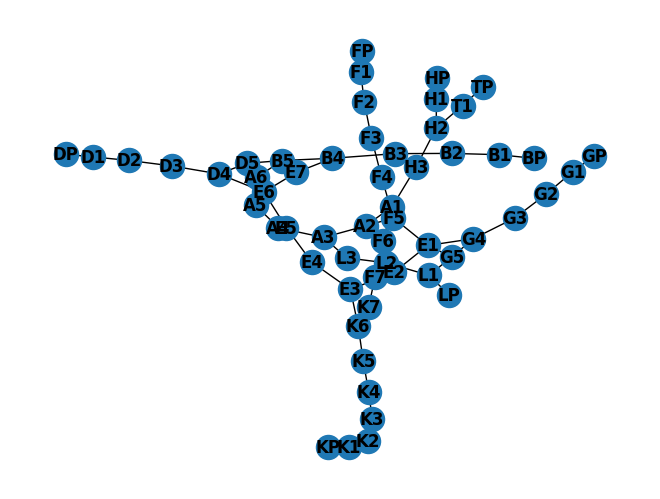

In [12]:
import matplotlib.pyplot as plt

nx.draw(grafoRedT, with_labels=True, font_weight='bold')
plt.show()